# Classification

The goal of classification is to find a function that separates the data into positive/negative labels. In the case of a linear classifier, this reduces to finding a set of parameters $w^\star$ such that, $$ \begin{align} w^\star &= \arg \min_w \sum_{i=1}^{N} \left[y_i\neq \text{sign} (w^\top x_i) \right] \\ &= \arg \min_w \sum_{i=1}^{N} l_{0/1} (w; x_i, y_i) \end{align}.$$ 

The problem with the $l_{0/1}$ loss, is that it is non-convex (and non-differentiable), hence other surrogate losses must be used to optimize the number of points. 

In [1]:
# Code source: Sebastian Curi and Andreas Krause, based on Jaques Grobler (sklearn demos).
# License: BSD 3 clause

# We start importing some modules and running some magic commands
% matplotlib inline
% reload_ext autoreload
% load_ext autoreload
% autoreload 2

# General math and plotting modules.
import numpy as np
import matplotlib.pyplot as plt

# Project files.
from util import gradient_descent, generate_linear_separable_data, generate_circular_separable_data
import plot_helpers
from classifiers import Perceptron, SVM, Logistic
from regularizers import L1Regularizer, L2Regularizer

# Widget and formatting modules
import ipywidgets
from ipywidgets import interact, interactive, interact_manual
import pylab
# If in your browser the figures are not nicely vizualized, change the following line. 
pylab.rcParams['figure.figsize'] = (10, 5)

# Machine Learning library. 
import sklearn
from sklearn import svm
from sklearn.linear_model import SGDClassifier

import warnings
warnings.filterwarnings('ignore')
# from sklearn import datasets, linear_model


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


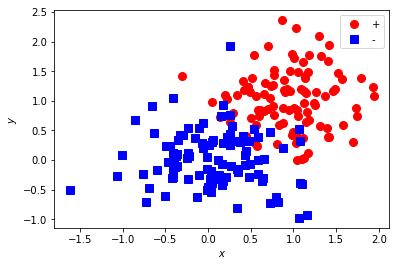

In [2]:
num_points = 100  # Number of points per class
noise = 0.5  # Noise Level (needed for data generation).
np.random.seed(42)
X, Y = generate_linear_separable_data(num_points, noise=noise, dim=2)
# X = X - np.mean(X)

fig = plt.subplot(111)
opt = {'marker': 'ro', 'label': '+', 'size': 8}
plot_helpers.plot_data(X[np.where(Y == 1)[0], 0], X[np.where(Y == 1)[0], 1], fig=fig, options=opt)
opt = {'marker': 'bs', 'label': '-', 'x_label': '$x$', 'y_label': '$y$', 'size': 8, 'legend': True}
plot_helpers.plot_data(X[np.where(Y == -1)[0], 0], X[np.where(Y == -1)[0], 1], fig=fig, options=opt)

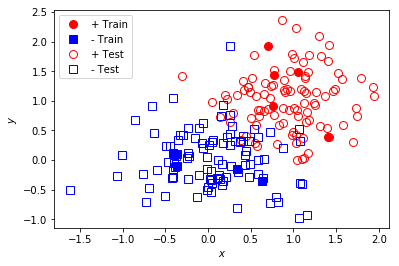

In [3]:
# Separate into train and test sets!
np.random.seed(42)
indexes = np.arange(0, 2*num_points, 1)
np.random.shuffle(indexes)
num_train = int(np.ceil(2*.05*num_points))

X_train = X[indexes[:num_train]]
Y_train = Y[indexes[:num_train]]

X_test = X[indexes[num_train:]]
Y_test = Y[indexes[num_train:]]

fig = plt.subplot(111)

opt = {'marker': 'ro', 'fillstyle': 'full', 'label': '+ Train', 'size': 8}
plot_helpers.plot_data(X_train[np.where(Y_train == 1)[0], 0], X_train[np.where(Y_train == 1)[0], 1], fig=fig, options=opt)
opt = {'marker': 'bs', 'fillstyle': 'full', 'label': '- Train', 'size': 8}
plot_helpers.plot_data(X_train[np.where(Y_train == -1)[0], 0], X_train[np.where(Y_train == -1)[0], 1], fig=fig, options=opt)

opt = {'marker': 'ro', 'fillstyle': 'none', 'label': '+ Test', 'size': 8}
plot_helpers.plot_data(X_test[np.where(Y_test == 1)[0], 0], X_test[np.where(Y_test == 1)[0], 1], fig=fig, options=opt)
opt = {'marker': 'bs', 'fillstyle': 'none', 'label': '- Test', 'size': 8, 
       'x_label': '$x$', 'y_label': '$y$', 'legend': True}
plot_helpers.plot_data(X_test[np.where(Y_test == -1)[0], 0], X_test[np.where(Y_test == -1)[0], 1], fig=fig, options=opt)


## The Perceptron Algorithm

The perceptron loss is defined as: $$L(w; X, Y) =  \sum_{i=1}^{N} L_p(w; x_i, y_i) = \sum_{i=1}^{N} \max \{ 0, -y_i w^\top x_i \}.$$

The loss function is continuous, but not differentialbe at $y_i w^\top x_i=0$. The subgradient, however, exists and hence (stochastic) gradient descent converges. The subgradient is:

$$ \partial L_p(w; x_i,y_i) = \left\{\begin{array}{cc} 0 & \text{if } -y_i w^\top x_i < 0 \\ -y_i x_i & \text{if } -y_i w^\top x_i > 0 \\ \left[0, -y_i x_i \right] & \text{if } -y_i w^\top x_i = 0 \end{array}  \right. $$

In [4]:
def change_learning_params(reg, eta0, n_iter, batch_size):
    classifier = Perceptron(X_train, Y_train)
    classifier.load_test_data(X_test, Y_test)
    
    regularizer = L2Regularizer(np.power(10., reg))
    np.random.seed(42)
    w0 = np.random.randn(3, )

    opts = {'eta0': eta0,
            'n_iter': n_iter,
            'batch_size': batch_size,
            'n_samples': X_train.shape[0],
            'algorithm': 'SGD',
            'learning_rate_scheduling': None,
            }
    trajectory, indexes = gradient_descent(w0, classifier, regularizer, opts)

    contour_plot = plt.subplot(121)
    error_plot = plt.subplot(122)
    
    opt = {'marker': 'ro', 'fillstyle': 'full', 'label': '+ Train', 'size': 8}
    plot_helpers.plot_data(X_train[np.where(Y_train == 1)[0], 0], X_train[np.where(Y_train == 1)[0], 1], fig=contour_plot, options=opt)
    opt = {'marker': 'bs', 'fillstyle': 'full', 'label': '- Train', 'size': 8}
    plot_helpers.plot_data(X_train[np.where(Y_train == -1)[0], 0], X_train[np.where(Y_train == -1)[0], 1], fig=contour_plot, options=opt)

    opt = {'marker': 'ro', 'fillstyle': 'none', 'label': '+ Test', 'size': 8}
    plot_helpers.plot_data(X_test[np.where(Y_test == 1)[0], 0], X_test[np.where(Y_test == 1)[0], 1], fig=contour_plot, options=opt)
    opt = {'marker': 'bs', 'fillstyle': 'none', 'label': '- Test', 'size': 8}
    plot_helpers.plot_data(X_test[np.where(Y_test == -1)[0], 0], X_test[np.where(Y_test == -1)[0], 1], fig=contour_plot, options=opt)

    contour_opts = {'n_points': 50, 'x_label': '$x$', 'y_label': '$y$', 'sgd_point': True, 'n_classes': 4}
    error_opts = {'epoch': 5, 'x_label': '$t$', 'y_label': 'error'}
    
    opts = {'contour_opts': contour_opts, 'error_opts': error_opts}
    plot_helpers.classification_progression(X, Y, trajectory, indexes, classifier, 
                                            contour_plot=contour_plot, error_plot=error_plot, 
                                            options=opts)

interact_manual(change_learning_params,
                reg=ipywidgets.FloatSlider(value=-3,
                                    min=-3,
                                    max=3,
                                    step=0.5,
                                    readout_format='.1f',
                                    description='Regularization 10^:',
                                    style={'description_width': 'initial'},
                                    continuous_update=False), 
                eta0=ipywidgets.FloatSlider(value=1,
                                            min=1e-1,
                                            max=2,
                                            step=1 * 1e-1,
                                            readout_format='.1f',
                                            description='Learning rate:',
                                            style={'description_width': 'initial'},
                                            continuous_update=False),
                n_iter=ipywidgets.IntSlider(value=30,
                                            min=5,
                                            max=100,
                                            step=1,
                                            description='Number of iterations:',
                                            style={'description_width': 'initial'},
                                            continuous_update=False),
                batch_size=ipywidgets.IntSlider(value=1,
                                            min=1,
                                            max=X_train.shape[0],
                                            step=1,
                                            description='Batch Size:',
                                            style={'description_width': 'initial'},
                                            continuous_update=False)
               );

interactive(children=(FloatSlider(value=-3.0, continuous_update=False, description='Regularization 10^:', max=…

## The SVM Algorithm

The svm loss is defined as: $$L(w; X, Y) =  \sum_{i=1}^{N} L_{\text{svm}} (w; x_i, y_i) =  \sum_{i=1}^{N} \max \{ 0, 1-y_i w^\top x_i \}.$$

The loss function is continuous, but not differentialbe at $y_i w^\top x_i=0$. The subgradient, however, exists and hence (stochastic) gradient descent converges. The subgradient is:

$$ \partial L_{\text{svm}}(w;x_i,y_i) = \left\{\begin{array}{cc} 0 & \text{if } 1-y_i w^\top x_i < 0 \\ -y_i x_i & \text{if } 1-y_i w^\top x_i > 0 \\ \left[0, -y_i x_i \right] & \text{if } 1-y_i w^\top x_i = 0 \end{array}  \right. $$

The difference with the perceptron loss is that the SVM loss includes a loss margin. 

In [ ]:
def change_learning_params(reg, eta0, n_iter, batch_size):
    classifier = SVM(X_train, Y_train)
    classifier.load_test_data(X_test, Y_test)
    
    regularizer = L2Regularizer(np.power(10., reg))
    np.random.seed(42)
    w0 = np.random.randn(3, )

    opts = {'eta0': eta0,
            'n_iter': n_iter,
            'batch_size': batch_size,
            'n_samples': X_train.shape[0],
            'algorithm': 'SGD',
            'learning_rate_scheduling': None
            }

    trajectory, indexes = gradient_descent(w0, classifier, regularizer, opts)
    
    contour_plot = plt.subplot(121)
    error_plot = plt.subplot(122)
    
    opt = {'marker': 'ro', 'fillstyle': 'full', 'label': '+ Train', 'size': 8}
    plot_helpers.plot_data(X_train[np.where(Y_train == 1)[0], 0], X_train[np.where(Y_train == 1)[0], 1], fig=contour_plot, options=opt)
    opt = {'marker': 'bs', 'fillstyle': 'full', 'label': '- Train', 'size': 8}
    plot_helpers.plot_data(X_train[np.where(Y_train == -1)[0], 0], X_train[np.where(Y_train == -1)[0], 1], fig=contour_plot, options=opt)

    opt = {'marker': 'ro', 'fillstyle': 'none', 'label': '+ Test', 'size': 8}
    plot_helpers.plot_data(X_test[np.where(Y_test == 1)[0], 0], X_test[np.where(Y_test == 1)[0], 1], fig=contour_plot, options=opt)
    opt = {'marker': 'bs', 'fillstyle': 'none', 'label': '- Test', 'size': 8}
    plot_helpers.plot_data(X_test[np.where(Y_test == -1)[0], 0], X_test[np.where(Y_test == -1)[0], 1], fig=contour_plot, options=opt)

    contour_opts = {'n_points': 100, 'x_label': '$x$', 'y_label': '$y$', 'sgd_point': True, 'n_classes': 4}
    error_opts = {'epoch': 5, 'x_label': '$t$', 'y_label': 'error'}
    
    opts = {'contour_opts': contour_opts, 'error_opts': error_opts}
    plot_helpers.classification_progression(X, Y, trajectory, indexes, classifier, 
                                            contour_plot=contour_plot, error_plot=error_plot, 
                                            options=opts)

interact_manual(change_learning_params,
                reg=ipywidgets.FloatSlider(value=-3,
                                    min=-3,
                                    max=3,
                                    step=0.5,
                                    readout_format='.1f',
                                    description='Regularization 10^:',
                                    style={'description_width': 'initial'},
                                    continuous_update=False), 
                eta0=ipywidgets.FloatSlider(value=1,
                                            min=1e-1,
                                            max=2,
                                            step=1 * 1e-1,
                                            readout_format='.1f',
                                            description='Learning rate:',
                                            style={'description_width': 'initial'},
                                            continuous_update=False),
                n_iter=ipywidgets.IntSlider(value=50,
                                            min=5,
                                            max=100,
                                            step=1,
                                            description='Number of iterations:',
                                            style={'description_width': 'initial'},
                                            continuous_update=False),
                batch_size=ipywidgets.IntSlider(value=1,
                                            min=1,
                                            max=X_train.shape[0],
                                            step=1,
                                            description='Batch Size:',
                                            style={'description_width': 'initial'},
                                            continuous_update=False)
               );

## The Logistic Regression Algorithm

The logistic loss is defined as: $$L(w; X, Y) = \sum_{i=1}^{N} L_{\sigma}(w; x_i, y_i) = \sum_{i=1}^{N} \log \left( 1 + \exp \left(-y_i w^\top x_i \right) \right) .$$

The loss function is differentiable, hence the gradient is:

$$ \frac{\partial L_{\sigma}(w; x_i, y_i)}{\partial w} = -\frac{\exp \left(-y_i w^\top x_i \right)}{1+\exp \left(-y_i w^\top x_i \right)} y x_i$$

In [ ]:
def change_learning_params(reg, eta0, n_iter, batch_size):
    classifier = Logistic(X_train, Y_train)
    classifier.load_test_data(X_test, Y_test)
    
    regularizer = L2Regularizer(np.power(10., reg))
    np.random.seed(42)
    w0 = np.random.randn(3, )

    opts = {'eta0': eta0,
            'n_iter': n_iter,
            'batch_size': batch_size,
            'n_samples': X_train.shape[0],
            'algorithm': 'SGD',
            'learning_rate_scheduling': 'AdaGrad'
            }

    trajectory, indexes = gradient_descent(w0, classifier, regularizer, opts)
    
    contour_plot = plt.subplot(121)
    error_plot = plt.subplot(122)
    
    opt = {'marker': 'ro', 'fillstyle': 'full', 'label': '+ Train', 'size': 8}
    plot_helpers.plot_data(X_train[np.where(Y_train == 1)[0], 0], X_train[np.where(Y_train == 1)[0], 1], fig=contour_plot, options=opt)
    opt = {'marker': 'bs', 'fillstyle': 'full', 'label': '- Train', 'size': 8}
    plot_helpers.plot_data(X_train[np.where(Y_train == -1)[0], 0], X_train[np.where(Y_train == -1)[0], 1], fig=contour_plot, options=opt)

    opt = {'marker': 'ro', 'fillstyle': 'none', 'label': '+ Test', 'size': 8}
    plot_helpers.plot_data(X_test[np.where(Y_test == 1)[0], 0], X_test[np.where(Y_test == 1)[0], 1], fig=contour_plot, options=opt)
    opt = {'marker': 'bs', 'fillstyle': 'none', 'label': '- Test', 'size': 8}
    plot_helpers.plot_data(X_test[np.where(Y_test == -1)[0], 0], X_test[np.where(Y_test == -1)[0], 1], fig=contour_plot, options=opt)

    contour_opts = {'n_points': 100, 'x_label': '$x$', 'y_label': '$y$', 'sgd_point': True, 'n_classes': 4}
    error_opts = {'epoch': 5, 'x_label': '$t$', 'y_label': 'error'}
    
    opts = {'contour_opts': contour_opts, 'error_opts': error_opts}
    plot_helpers.classification_progression(X, Y, trajectory, indexes, classifier, 
                                            contour_plot=contour_plot, error_plot=error_plot, 
                                            options=opts)

interact_manual(change_learning_params,
                reg=ipywidgets.FloatSlider(value=-3,
                                    min=-3,
                                    max=3,
                                    step=0.5,
                                    readout_format='.1f',
                                    description='Regularization 10^:',
                                    style={'description_width': 'initial'},
                                    continuous_update=False), 
                eta0=ipywidgets.FloatSlider(value=0.5,
                                            min=1e-1,
                                            max=2,
                                            step=1 * 1e-1,
                                            readout_format='.1f',
                                            description='Learning rate:',
                                            style={'description_width': 'initial'},
                                            continuous_update=False),
                n_iter=ipywidgets.IntSlider(value=100,
                                            min=5,
                                            max=50,
                                            step=1,
                                            description='Number of iterations:',
                                            style={'description_width': 'initial'},
                                            continuous_update=False),
                batch_size=ipywidgets.IntSlider(value=1,
                                            min=1,
                                            max=X_train.shape[0],
                                            step=1,
                                            description='Batch Size:',
                                            style={'description_width': 'initial'},
                                            continuous_update=False)
               );

# L1 Regularization

The L-1 regularization method uses a regularizer of the form $R(w) = ||w||_1$ which is non-differentiable. However, the subgradient exits and is:

$$\partial(||w|||_1) = \left\{\begin{array}{cc} \text{sign} (w)& \text{if } w \neq 0 \\ [-1, 1]  & \text{if } w = 0 \end{array} \right. $$

This regularization method penalizes weights and induces sparsity in the solutions. That is, most of the entries of the solution $w^\star$ will be zero. 

In [ ]:
num_positive = 50  # Number of points per class
num_negative = 50  # Number of points per class

noise = 0.3  # Noise Level (needed for data generation).

X, Y = generate_linear_separable_data(num_positive, num_negative, offset=np.array([1, .2]), noise=noise, dim=2)
X = X - np.mean(X, axis=0)

def regularization(regularizer, reg):
    np.random.seed(42)
    classifier = SGDClassifier(loss='hinge', penalty=regularizer, alpha = np.power(10., reg), random_state=1)
    classifier.fit(X[:,:2], Y)
    
    X0, X1 = X[:, 0], X[:, 1]
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = .02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    fig = plt.subplot(111)
    contour = plot_helpers.plot_contours(fig, classifier, xx, yy, cmap=plt.cm.jet, alpha=0.3)
    plt.colorbar(contour)
    opt = {'marker': 'r*', 'label': '+'}
    plot_helpers.plot_data(X[np.where(Y == 1)[0], 0], X[np.where(Y == 1)[0], 1], fig=fig, options=opt)
    opt = {'marker': 'bs', 'label': '-', 'legend': True}
    plot_helpers.plot_data(X[np.where(Y == -1)[0], 0], X[np.where(Y == -1)[0], 1], fig=fig, options=opt)
    
interact(regularization,
         regularizer=ipywidgets.RadioButtons(
             options=['l1', 'l2'],
             value='l1',
             description='Algorithm:',
             style={'description_width': 'initial'}),
         reg=ipywidgets.FloatSlider(
             value=-3,
             min=-3,
             max=0,
             step=0.5,
             description='Regularizer 10^:',
             style={'description_width': 'initial'},
             continuous_update=False)
         );

# Cost Sensitivity

When there are more positive than negative examples the then, to overcome this uneven distribution of data, the cost of mislabeling can be changed between classes. 

The cost can be expressed as:  $$ w^\star = \arg \min_w \sum_{i=1}^{N} c(y_i) \left[y_i\neq \text{sign} (w^\top x_i) \right], $$ 
where $c(y_i)$ is a cost that depends on the class. 


In [ ]:
num_positive = 20  # Number of points per class
num_negative = 100  # Number of points per class
noise = 0.3  # Noise Level (needed for data generation).

X, Y = generate_linear_separable_data(num_positive, num_negative, noise=noise, dim=2)
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC

def cost_sensitivity(algorithm, ratio):
    class_weight = {-1: 1, 1:np.power(10., ratio)}
    if algorithm == 'SVM':
        classifier = LinearSVC(class_weight=class_weight)
    elif algorithm == 'Perceptron':
        classifier = SGDClassifier(loss='perceptron', random_state=1, class_weight=class_weight)

    classifier.fit(X[:,:2], Y)
    
    X0, X1 = X[:, 0], X[:, 1]
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = .02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    fig = plt.subplot(111)
    plot_helpers.plot_contours(fig, classifier, xx, yy, cmap=plt.cm.jet, alpha=0.3)
    opt = {'marker': 'r*', 'label': '+'}
    plot_helpers.plot_data(X[np.where(Y == 1)[0], 0], X[np.where(Y == 1)[0], 1], fig=fig, options=opt)
    opt = {'marker': 'bs', 'label': '-'}
    plot_helpers.plot_data(X[np.where(Y == -1)[0], 0], X[np.where(Y == -1)[0], 1], fig=fig, options=opt)

    
interact(cost_sensitivity,
         algorithm=ipywidgets.RadioButtons(
             options=['SVM', 'Perceptron'],
             value='SVM',
             description='Algorithm:',
             style={'description_width': 'initial'}),
         ratio=ipywidgets.FloatSlider(
             value=0,
             min=-1,
             max=3,
             step=0.5,
             description='Cost Ratio 10^:',
             style={'description_width': 'initial'},
             continuous_update=False)
         );

# Multiclass Classification

In multiclass classification there are two strategies: OvO (One vs One) or OvR (One vs The Rest). 

In [ ]:
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn import datasets
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

np.random.seed(1)
iris = datasets.load_iris()
X, y = iris.data[:,:2], iris.target
mean = X.mean(axis=0)
std = X.std(axis=0)
X = (X - mean) / std

def multiclass(strategy):
    if strategy == 'OvO':
        classifier =  OneVsOneClassifier(SGDClassifier(loss='perceptron', alpha=0.001, n_iter=100, random_state=0))
#         classifier =  OneVsOneClassifier(LinearSVC(random_state=0))
        colors = ['g', 'r', 'b']
    elif strategy == 'OvR' or strategy == 'OvA':
        classifier =  OneVsRestClassifier(SGDClassifier(loss='perceptron', alpha=0.001, n_iter=100, random_state=0))
#         classifier =  OneVsRestClassifier(LinearSVC(random_state=0))
        colors = ['b', 'g', 'r']
        

    classifier.fit(X, y)
    X0, X1 = X[:, 0], X[:, 1]
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = .02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    fig = plt.subplot(111)
    plot_helpers.plot_contours(fig, classifier, xx, yy, cmap=plt.cm.jet, alpha=0.3)
    
    opt = {'marker': 'bs', 'label': '-', 'x_label': '$x$', 'y_label': '$y$', 'size': 8}
    plot_helpers.plot_data(X[np.where(y == 0)[0], 0], X[np.where(y == 0)[0], 1], fig=fig, options=opt)
    opt = {'marker': 'g*', 'label': '+', 'size': 8}
    plot_helpers.plot_data(X[np.where(y == 1)[0], 0], X[np.where(y == 1)[0], 1], fig=fig, options=opt)
    opt = {'marker': 'ro', 'label': '-', 'x_label': '$x$', 'y_label': '$y$', 'size': 8, 'legend': True}
    plot_helpers.plot_data(X[np.where(y == 2)[0], 0], X[np.where(y == 2)[0], 1], fig=fig, options=opt)
    

    def plot_hyperplane(clf, color):
        coef = clf.coef_
        intercept = clf.intercept_
        def line(x0):
            return (-(x0 * coef[0, 0]) - intercept[0]) / coef[0, 1]

        plt.plot([x_min, x_max], [line(x_min), line(x_max)],
                 ls="--", color=color)

    
    for estimator, color in zip(classifier.estimators_, colors):
        plot_hyperplane(estimator, color)

    fig.set_xlim([x_min, x_max])
    fig.set_ylim([y_min, y_max]);

interact(multiclass, strategy=['OvO', 'OvA']); 